In [70]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [71]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [72]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [73]:
filenames=['../input/ddsm-mammography/training10_2/training10_2.tfrecords',
#          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
#           '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
#           '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
#           '../input/ddsm-mammography/training10_4/training10_4.tfrecords']
          ]

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
11177
11177


In [74]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True)

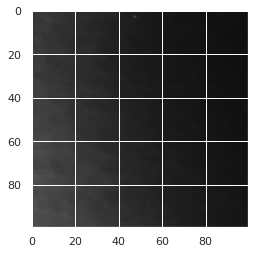

In [75]:
plt.imshow(x_train[0])

In [76]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 3)


In [77]:
rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = InceptionResNetV2(input_shape=(100,100,3), weights='imagenet', include_top=False)
x = base_model.output
predictions = Flatten()(x)
# predictions = Dropout(0.3)(x)
# x = BatchNormalization()(x)
# x = Dense(128,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x =  Dropout(0.2)(x)

# predictions = Dense(8, activation='softmax')(x)
model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
test_features=model_feat.predict(x_test)

(100, 100, 3)


In [78]:
train_features[0].shape

(1536,)

In [79]:
x_train_acc, x_val_acc, y_train_acc, y_val_acc = train_test_split(train_features,y_train,
                                                  test_size = 0.2,
                                                  stratify = y_train,
                                                  shuffle = True,
                                                  random_state = 42)
X_test,y_test=test_features,y_test

In [80]:
print('length X_train:', len(x_train_acc))
print('length y_train:', len(y_train_acc))

print('length X_val:',  len(x_val_acc))
print('length y_val:', len(y_val_acc))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 7152
length y_train: 7152
length X_val: 1789
length y_val: 1789
length X_test: 2236
length y_test: 2236


In [81]:
names = [
        "K Nearest Neighbour Classifier",
        'SVM',
        "Random Forest Classifier",
        "AdaBoost Classifier", 
        "XGB Classifier",
         ]
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
        ]

zipped_clf = zip(names,classifiers)

In [82]:
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    
    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)
    
    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)
    train_confusion_matrix = confusion_matrix(y_train,y_pred_train)
    
    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)
    val_confusion_matrix = confusion_matrix(y_val,y_pred_val)
    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4) 
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)
    
    
    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(train_accuracy))
    print("F1_score : {}".format(train_F1))
    print("Cohen Kappa Score : {} ".format(train_kappa))
    print("Recall : {}".format(train_recall))
    print("Precision : {}".format(train_precision))
    print("Confusion Matrix :\n {}".format(train_confusion_matrix))
    
    print()
    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(val_accuracy))
    print("F1_score : {}".format(val_F1))
    print("Cohen Kappa Score : {} ".format(val_kappa))
    print("Recall : {}".format(val_recall))
    print("Precision : {}".format(val_precision))
    print("Confusion Matrix :\n {}".format(val_confusion_matrix))
    
    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

In [83]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf): 
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('classifier', c)])
        print("Fitting {} on features ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [84]:
classifier_comparator(x_train_acc,y_train_acc,x_val_acc,y_val_acc,X_test,y_test,classifier=zipped_clf)

Fitting K Nearest Neighbour Classifier on features 

------------------------ Train Set Metrics------------------------

accuracy : 88.77000000000001%
F1_score : 0.8625
Cohen Kappa Score : 0.3055 
Recall : 0.8877
Precision : 0.8705
Confusion Matrix :
 [[6132   95]
 [ 708  217]]

------------------------ Validation Set Metrics------------------------

accuracy : 85.52%
F1_score : 0.8196
Cohen Kappa Score : 0.0851 
Recall : 0.8552
Precision : 0.803
Confusion Matrix :
 [[1509   48]
 [ 211   21]]

------------------------ Test Set Metrics------------------------

accuracy : 86.53999999999999%
F1_score : 0.8363
Cohen Kappa Score : 0.1285 
Recall : 0.8654
Precision : 0.8233
Confusion Matrix : [[1901   63]
 [ 238   34]]
--------------------------------------------------------------------------------

Fitting SVM on features 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Train Set Metrics------------------------

accuracy : 87.07000000000001%
F1_score : 0.8105
Cohen Kappa Score : 0.0 
Recall : 0.8707
Precision : 0.7581
Confusion Matrix :
 [[6227    0]
 [ 925    0]]

------------------------ Validation Set Metrics------------------------

accuracy : 87.03%
F1_score : 0.81
Cohen Kappa Score : 0.0 
Recall : 0.8703
Precision : 0.7575
Confusion Matrix :
 [[1557    0]
 [ 232    0]]

------------------------ Test Set Metrics------------------------

accuracy : 87.83999999999999%
F1_score : 0.8215
Cohen Kappa Score : 0.0 
Recall : 0.8784
Precision : 0.7715
Confusion Matrix : [[1964    0]
 [ 272    0]]
--------------------------------------------------------------------------------

Fitting Random Forest Classifier on features 

------------------------ Train Set Metrics------------------------

accuracy : 100.0%
F1_score : 1.0
Cohen Kappa Score : 1.0 
Recall : 1.0
Precision : 1.0
Confusion Matrix :
 [[6227    0]
 [   0  925]]

-------

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

------------------------ Train Set Metrics------------------------

accuracy : 99.9%
F1_score : 0.999
Cohen Kappa Score : 0.9956 
Recall : 0.999
Precision : 0.999
Confusion Matrix :
 [[6227    0]
 [   7  918]]

------------------------ Validation Set Metrics------------------------

accuracy : 85.47%
F1_score : 0.8258
Cohen Kappa Score : 0.1294 
Recall : 0.8547
Precision : 0.812
Confusion Matrix :
 [[1498   59]
 [ 201   31]]

------------------------ Test Set Metrics------------------------

accuracy : 86.45%
F1_score : 0.8427
Cohen Kappa Score : 0.1802 
Recall : 0.8645
Precision : 0.8316
Confusion Matrix : [[1884   80]
 [ 223   49]]
--------------------------------------------------------------------------------



In [85]:
ann=Sequential()
ann.add(Dense(16,activation='relu',input_shape=x_train_acc[0].shape))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(16,activation='relu'))
ann.add(Dense(1,activation='sigmoid'))

ann.summary()

ann.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = ann.fit(x_train_acc, y_train_acc,validation_data=(x_val_acc,y_val_acc), epochs=10)

loss_value , accuracy = ann.evaluate(x_train_acc, y_train_acc)
print('Train_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(x_val_acc, y_val_acc)
print('Validation_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(X_test, y_test)
print('test_accuracy = ' + str(accuracy))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 16)                24592     
_________________________________________________________________
dense_57 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_58 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_59 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_60 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_61 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                

In [86]:
y_pred=ann.predict_classes(X_test)
target=["B","M"]
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.8784
F1 Score: 0.8215
Cohen Kappa Score: 0.0
Recall: 0.8784
Precision: 0.7715
		Classification Report:
               precision    recall  f1-score   support

           B       0.88      1.00      0.94      1964
           M       0.00      0.00      0.00       272

    accuracy                           0.88      2236
   macro avg       0.44      0.50      0.47      2236
weighted avg       0.77      0.88      0.82      2236



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being 